# Detecting machine VS human-generated Wikipedia articles

## 1. Creating the dataset

The idea is to get a small subset of articles from the [WikiText-2](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/) dataset, and run the first couple of sentences of each post through a [gpt2-large](https://huggingface.co/transformers/v2.1.1/pretrained_models.html) pre-trained language model to generate fake content. This would allow us to have the same number (~300) of human-curated and machine-faked articles.  

In [9]:
#!pip install transformers

In [10]:
#!pip install torchtext

### Imports

In [ ]:
import pandas as pd
import argparse
import numpy as np
import torch
from os import path
from pathlib import Path
import os
import random
from shutil import copyfile

from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer
)

### Reading a subset of the `wikitext-2` dataset into a dataframe

In [2]:
wikitext = pd.read_csv('/home/ec2-user/.fastai/data/wikitext-2/test.csv', header=None)
wikitext = wikitext.append(pd.read_csv('/home/ec2-user/.fastai/data/wikitext-2/train.csv', header=None))
wikitext.reset_index(inplace=True)

wikitext.shape

(662, 2)

In [3]:
wikitext.head()

,index,0
0,0,"\n = Tropical Storm <unk> ( 2008 ) = \n \n Tropical Storm <unk> was the tenth tropical storm of the 2008 Atlantic hurricane season . <unk> developed out of a strong tropical wave which moved off the African coast on August 31 . The wave quickly became organized and was declared Tropical Depression Ten while located 170 mi ( 270 km ) to the south @-@ southeast of the Cape Verde Islands on September 2 . The depression was quickly upgraded to Tropical Storm <unk> around noon the same day . Over the next several days , <unk> moved in a general west @-@ northwest direction and reached its peak..."
1,1,"\n = Calvin <unk> = \n \n Calvin <unk> ( born November 2 , 1984 ) is a Canadian football running back for the Edmonton <unk> of the Canadian Football League ( <unk> ) . He played as a <unk> until 2014 , when he became the starting fullback for the <unk> . <unk> is known for being able to fill many roles at his position , with <unk> <unk> Chris Schultz noting in 2010 that he is a "" multi @-@ purpose running back who catches the ball extremely well , blocks well and runs well "" . He is a champion of the <unk> Grey Cup . \n Prior to being drafted by the Edmonton <unk> in the fourth round of ..."
2,2,"\n = The Boat Race 2008 = \n \n The <unk> Boat Race took place on 29 March 2008 . Held annually , the event is a side @-@ by @-@ side rowing race between crews from the Universities of Oxford and Cambridge along the River Thames . Oxford won the race . Oxford 's crew featured the oldest competitor in Boat Race history . The race took place in very difficult weather conditions – strong winds and heavy rain – resulting in the slowest winning time in over sixty years . Oxford won by six lengths , the largest margin of victory since the 2004 race . \n Oxford 's Isis beat Cambridge 's Goldie i..."
3,3,"\n = Angel of Death ( Slayer song ) = \n \n "" Angel of Death "" is the opening track on the American thrash metal band Slayer 's 1986 album Reign in Blood . The lyrics and music were written by Slayer guitarist , Jeff Hanneman and are based on Nazi physician <unk> <unk> , who conducted human experiments at the Auschwitz concentration camp during World War II . "" Angel of Death "" led to the band facing accusations of Nazi <unk> and racism throughout their career . \n Despite the controversy surrounding the song and its contribution to the delay in the release of Reign in Blood , "" Angel of ..."
4,4,"\n = 2011 – 12 Michigan Wolverines men 's basketball team = \n \n The 2011 – 12 Michigan Wolverines men 's basketball team represented the University of Michigan during the 2011 – 12 NCAA Division I men 's basketball season . The team played its home games in Ann Arbor , Michigan at <unk> Center for the <unk> consecutive year . It had a seating capacity of 12 @,@ <unk> . It was also the team 's <unk> straight season as a member of the Big Ten Conference . Fifth @-@ year head coach John <unk> led the team , alongside All @-@ Big Ten players Trey Burke , Tim <unk> , Jr. and Zack Novak . Bur..."


### Setting up the Huggingface pipeline for the `gpt2-large` LM

In [13]:
DEVICE = 'cpu'
LENGTH = 900
TEMPERATURE = 1.0
K = 0
P = 0.9
REPETITION_PENALTY = 1.0
NUM_RETURN_SEQUENCES = 1
STOP_TOKEN = None

def save_text(o, path):
    with open(path, "w") as output_file:
        output_file.write(o)
        
def generate_text(index):
    doc = wikitext.loc[index, 0]
    dot = doc[400:len(doc)].find(".")
    prompt_text = doc[:(400+dot+1)]
    
    encoded_prompt = tokenizer.encode(prompt_text, add_special_tokens=False, return_tensors="pt")
    encoded_prompt = encoded_prompt.to(DEVICE)

    output_sequences = model.generate(
        input_ids=encoded_prompt,
        max_length=LENGTH + len(encoded_prompt[0]),
        temperature=TEMPERATURE,
        top_k=K,
        top_p=P,
        repetition_penalty=REPETITION_PENALTY,
        do_sample=True,
        num_return_sequences=NUM_RETURN_SEQUENCES
    )

    generated_sequence = output_sequences[0].tolist()
    # Decode text
    text = tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True)
    # Remove all text after the stop token
    text = text[: text.find(STOP_TOKEN) if STOP_TOKEN else None]

    # Add the prompt at the beginning of the sequence. Remove the excess text that was used for pre-processing
    total_sequence = (prompt_text + text[len(tokenizer.decode(encoded_prompt[0], clean_up_tokenization_spaces=True)) :])
    total_sequence = total_sequence[:(total_sequence.rfind(".")+1)]
    
    save_text(total_sequence, 
              f"/home/ec2-user/SageMaker/course-v4/nbs/wikitext/machine/{index}.txt")
    save_text(wikitext.loc[index, 0][: (wikitext.loc[index, 0][:len(total_sequence)].rfind(".")+1)], 
              f"/home/ec2-user/SageMaker/course-v4/nbs/wikitext/human/{index}.txt")
    print(index, len(generated_sequence))

### Loading the LM

In [19]:
model, tokenizer = GPT2LMHeadModel, GPT2Tokenizer

# RUN THE FOLLOWING IF YOU EXECUTE THIS CELL FOR THE FIRST TIME.
# THIS IS TO DOWNLOAD THE PRE-TRAINED WEIGHTS FROM HUGGINGFACE
# tokenizer = tokenizer.from_pretrained('gpt2-large')
# model = model.from_pretrained('gpt2-large')

mydir = "./gpt2/"

if path.isdir(mydir):
    tokenizer = tokenizer.from_pretrained(mydir)
    model = model.from_pretrained(mydir)
else:
    tokenizer.save_pretrained(mydir)
    model.save_pretrained(mydir)

model.to(DEVICE);

### Feeding the LM with the first 2 sentences of a real article and it generate fake text

In [ ]:
for i in wikitext.index:
    try: 
        generate_text(i)
    except: 
        pass

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


0 989


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


1 902


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


2 1004


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


3 1002


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


4 1009


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


35 725


### Creating an appropriate folder structure to be able to build a DL dataset in a more convenient way

```
+ wikifake_tiny
+-- train
    +-- human
    +-- machine
+-- valid
    +-- human
    +-- machine
```

In [4]:
!ls ./wikifake_tiny/

models	train  valid


In [5]:
!ls ./wikifake_tiny/train

human  machine


In [6]:
path = Path("./wikitext/")

In [4]:
random.seed(0)
machine = os.listdir(path/"machine")
n = int(len(machine) * 0.2)
valid = random.sample(machine, n)
train = [t for t in machine if t not in valid]

assert (len(train)+len(valid))==len(machine)

d = {'train': train, 'valid': valid}
len(d['valid']), len(d['train'])

(67, 268)

In [6]:
(len(d['valid']) + len(d['train'])) * 2

670

In [5]:
src = "./wikitext/"
dst = "./wikifake_tiny/"

for j in ['machine', 'human']:
    for k in ['valid', 'train']:
        for t in d[k]:
            copyfile(os.path.join(src, j, t), os.path.join(dst, k, j, t))

### Let's check an example from `human` and...

In [11]:
f = Path("./wikifake_tiny/valid/human/104.txt").read(); print(f)

 
 = Jin – Song Wars = 
 
 The Jin – Song Wars were a series of conflicts between the Jurchen Jin dynasty ( 1115 – 1234 ) and Han Chinese Song dynasty ( 960 – 1279 ) . In 1115 , the Jurchens rebelled against their overlords , the <unk> Liao dynasty ( 907 – 1125 ) , and declared the formation of the Jin . <unk> with the Song against their common enemy the Liao , the Jin promised to return to the Song the territories in northern China that had fallen under Liao control since 938 . The Jurchens ' quick defeat of the Liao combined with Song military failures made the Jin reluctant to cede these territories . After a series of failed negotiations that <unk> both sides , the Jurchens attacked the Song in November 1125 , dispatching one army towards Taiyuan and the other towards Kaifeng , the Song capital . 
 <unk> by the news of an invasion , the Song general stationed in Taiyuan retreated from the city , which was besieged and later captured . As the second Jin army approached the capital ,

### ... the same from `machine`, e.g. the LM's output triggered by the first 3 sentences from the previous article

> = Jin – Song Wars = The Jin – Song Wars were a series of conflicts between the Jurchen Jin dynasty ( 1115 – 1234 ) and Han Chinese Song dynasty ( 960 – 1279 ) . In 1115 , the Jurchens rebelled against their overlords , the <unk> Liao dynasty ( 907 – 1125 ) , and declared the formation of the Jin . <unk> with the Song against their common enemy the Liao , the Jin promised to return to the Song the territories in northern China that had fallen under Liao control since 938 .

In [12]:
f = Path("./wikifake_tiny/valid/machine/104.txt").read(); print(f)

 
 = Jin – Song Wars = 
 
 The Jin – Song Wars were a series of conflicts between the Jurchen Jin dynasty ( 1115 – 1234 ) and Han Chinese Song dynasty ( 960 – 1279 ) . In 1115 , the Jurchens rebelled against their overlords , the <unk> Liao dynasty ( 907 – 1125 ) , and declared the formation of the Jin . <unk> with the Song against their common enemy the Liao , the Jin promised to return to the Song the territories in northern China that had fallen under Liao control since 938 . They raised a number of brigades and raised fierce banners in honour of the imprisoned Sun emperor of Han. However, the Song conquests in China slowed dramatically during the first years of the Song's reign. But the Jurchen government backed off by official withdrawals of troops and the exportation of many wealth goods, the Han Rebellion, a religious uprising, began in 1118. All the provinces of China became subservient to the Song, from Jin to Shanghai. Then the Song retook most of the lands in the south, the 

## 2. Training a text classifier to detect `human` VS `machine` articles

This section (in large part) runs the code from [this NLP fastbook notebook](https://github.com/fastai/fastbook/blob/master/clean/10_nlp.ipynb).

In [1]:
from utils import *
from fastai2.text.all import *

In [2]:
path = Path("./wikifake_tiny/")
files = get_text_files(path, folders = ['train', 'valid'])
files

(#670) [Path('wikifake_tiny/train/machine/299.txt'),Path('wikifake_tiny/train/machine/260.txt'),Path('wikifake_tiny/train/machine/166.txt'),Path('wikifake_tiny/train/machine/11.txt'),Path('wikifake_tiny/train/machine/111.txt'),Path('wikifake_tiny/train/machine/317.txt'),Path('wikifake_tiny/train/machine/44.txt'),Path('wikifake_tiny/train/machine/278.txt'),Path('wikifake_tiny/train/machine/206.txt'),Path('wikifake_tiny/train/machine/19.txt')...]

In [3]:
txt = files[0].open().read(); txt

' \n = Hugh Walpole = \n \n Sir Hugh Seymour Walpole , CBE ( 13 March 1884 – 1 June 1941 ) was an English novelist . He was the son of an Anglican clergyman , intended for a career in the church but drawn instead to writing . Among those who encouraged him were the authors Henry James and Arnold Bennett . His skill at scene @-@ setting and vivid plots , as well as his high profile as a lecturer , brought him a large readership in the United Kingdom and North America . He died in 1944. His 1929 short story, "The Invisible Man" from his collection The Rothed Committee, remains a popular one-liner, and is quoted frequently by modern authors.'

### Tokenizing text and converting tokens into numbers

In [4]:
spacy = WordTokenizer()
toks = first(spacy([txt]))
print(coll_repr(toks, 50))

(#132) [' \n ','=','Hugh','Walpole','=','\n \n ','Sir','Hugh','Seymour','Walpole',',','CBE','(','13','March','1884','–','1','June','1941',')','was','an','English','novelist','.','He','was','the','son','of','an','Anglican','clergyman',',','intended','for','a','career','in','the','church','but','drawn','instead','to','writing','.','Among','those'...]


In [5]:
tkn = Tokenizer(spacy)
print(coll_repr(tkn(txt), 50))

(#161) ['xxbos','=','xxmaj','hugh','xxmaj','walpole','=','\n \n ','xxmaj','sir','xxmaj','hugh','xxmaj','seymour','xxmaj','walpole',',','xxup','cbe','(','13','xxmaj','march','1884','–','1','xxmaj','june','1941',')','was','an','xxmaj','english','novelist','.','xxmaj','he','was','the','son','of','an','xxmaj','anglican','clergyman',',','intended','for','a'...]


In [6]:
txts = L(o.open().read() for o in files)

In [7]:
toks_all = txts.map(tkn)
toks_all

(#670) [(#161) ['xxbos','=','xxmaj','hugh','xxmaj','walpole','=','\n \n ','xxmaj','sir'...],(#966) ['xxbos','=','xxmaj','june','1941','uprising','in','eastern','xxmaj','herzegovina'...],(#165) ['xxbos','=','xxmaj','tower','xxmaj','building','of','the','xxmaj','little'...],(#1025) ['xxbos','=','xxmaj','the','xxunk','xxmaj','blues','=','\n \n ','"'...],(#346) ['xxbos','=','xxmaj','robbie','xxmaj','fowler','=','\n \n ','xxmaj','robert'...],(#783) ['xxbos','=','xxmaj','astraeus','hygrometricus','=','\n \n ','xxmaj','astraeus','hygrometricus'...],(#540) ['xxbos','=','xxmaj','frank','xxunk','=','\n \n ','xxmaj','air','xxmaj'...],(#1089) ['xxbos','=','xxmaj','first','xxmaj','battle','of','xxmaj','maryang','xxmaj'...],(#182) ['xxbos','=','xxmaj','soviet','cruiser','xxmaj','krasnyi','xxmaj','kavkaz','='...],(#913) ['xxbos','=','1985','xxunk','assassination','plot','=','\n \n ','xxmaj','the'...]...]

In [8]:
num = Numericalize()
num.setup(toks_all)
coll_repr(num.vocab,50)

'(#9840) [\'xxunk\',\'xxpad\',\'xxbos\',\'xxeos\',\'xxfld\',\'xxrep\',\'xxwrep\',\'xxup\',\'xxmaj\',\'the\',\',\',\'.\',\'of\',\'and\',\'in\',\'a\',\'to\',\'was\',\'"\',\'=\',\'(\',\')\',\'-\',\'is\',\'on\',\'as\',\'by\',\'for\',\'that\',\'with\',"\'s",\'it\',\'at\',\'from\',\'\\n\',\'he\',\'\\n \\n \',\'his\',\'an\',\':\',\'were\',\'which\',\'this\',\'\\n \',\'first\',\'be\',\'are\',\'had\',"\'",\'not\'...]'

In [9]:
num.encodes(tkn(txt))[:20]

tensor([   2,   19,    8, 2393,    8, 5894,   19,   36,    8, 1968,    8, 2393,    8, 4720,    8, 5894,   10,    7, 6725,   20])

In [10]:
' '.join(tkn(txt)[:20])

'xxbos = xxmaj hugh xxmaj walpole = \n \n  xxmaj sir xxmaj hugh xxmaj seymour xxmaj walpole , xxup cbe ('

In [11]:
' '.join(num.decodes(num.encodes(tkn(txt)))[:20])

'xxbos = xxmaj hugh xxmaj walpole = \n \n  xxmaj sir xxmaj hugh xxmaj seymour xxmaj walpole , xxup cbe ('

In [12]:
' '.join([num.vocab[o] for o in num.encodes(tkn(txt))[:20]])

'xxbos = xxmaj hugh xxmaj walpole = \n \n  xxmaj sir xxmaj hugh xxmaj seymour xxmaj walpole , xxup cbe ('

### 2.a) Fine tuning a language model before moving to the actual classifier

In [63]:
dls_lm = DataBlock(
    blocks=TextBlock.from_folder(path, is_lm=True),
    get_items=get_text_files, 
    splitter=RandomSplitter(0.1)
).dataloaders(path, path=path, bs=128, seq_len=80)

In [66]:
x, y = first(dls_lm.train)
x.shape, y.shape, len(dls_lm.train)

(torch.Size([128, 60]), torch.Size([128, 60]), 53)

In [67]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos = xxmaj ghost in the xxmaj shell : xxmaj stand xxmaj alone xxmaj complex - xxmaj solid xxmaj state xxmaj society = \n▁\n▁ xxmaj ghost in the xxmaj shell : xxmaj stand xxmaj alone xxmaj complex - xxmaj solid xxmaj state xxmaj society ( xxmaj japanese : xxunk xxwrep 3 xxunk xxmaj solid xxmaj state xxmaj society , xxmaj","= xxmaj ghost in the xxmaj shell : xxmaj stand xxmaj alone xxmaj complex - xxmaj solid xxmaj state xxmaj society = \n▁\n▁ xxmaj ghost in the xxmaj shell : xxmaj stand xxmaj alone xxmaj complex - xxmaj solid xxmaj state xxmaj society ( xxmaj japanese : xxunk xxwrep 3 xxunk xxmaj solid xxmaj state xxmaj society , xxmaj hepburn"
1,"the team then went undefeated until 16 xxmaj february , when they faced xxmaj england . xxmaj officials of the strictly amateur xxmaj rugby xxmaj football xxmaj union ( xxup xxunk ) had become increasingly concerned at the behaviour of the xxmaj new xxmaj zealanders , regarding them as xxunk , and tensions reached a xxunk in the aftermath of","team then went undefeated until 16 xxmaj february , when they faced xxmaj england . xxmaj officials of the strictly amateur xxmaj rugby xxmaj football xxmaj union ( xxup xxunk ) had become increasingly concerned at the behaviour of the xxmaj new xxmaj zealanders , regarding them as xxunk , and tensions reached a xxunk in the aftermath of the"


In [68]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

In [69]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.179878,3.069241,0.415890,21.525564,00:50


In [70]:
learn.unfreeze()
learn.fit_one_cycle(5, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.741649,3.016871,0.419821,20.427279,01:00
1,2.631415,2.976815,0.427663,19.625206,01:00
2,2.373135,2.961053,0.433551,19.318310,01:00
3,2.117501,2.979997,0.436646,19.687752,01:00
4,1.910905,3.010571,0.435255,20.298992,01:01


In [71]:
learn.save_encoder('finetuned')

### 2.b) Training the classifier

In [13]:
dls_clas = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),
    get_y = parent_label,
    get_items=get_text_files,
    splitter=GrandparentSplitter()
).dataloaders(path, path=path, bs=128, seq_len=72)

In [14]:
dls_clas.show_batch(max_n=6)

,text,category
0,"xxbos = xxmaj the xxmaj remix ( xxmaj lady xxmaj gaga album ) = \n▁\n▁ xxmaj the xxmaj remix is a remix album by xxmaj american recording artist xxmaj lady xxmaj gaga . xxmaj released in xxmaj japan on xxmaj march 3 , 2010 , it contains remixes of the songs from her first studio album , xxmaj the xxmaj fame ( 2008 ) , and her third extended play , xxmaj the xxmaj fame xxmaj monster ( 2009 ) . a revised version of the track list was prepared for release in additional markets , beginning with xxmaj mexico on xxmaj may 3 , 2010 . \n xxmaj the xxmaj remix is a xxmaj remix album by xxmaj americ...",machine
1,"xxbos = 2007 xxmaj hawaii xxmaj bowl = \n▁\n▁ xxmaj the 2007 xxunk xxmaj hawaii xxmaj bowl was a post - season college football bowl game between the xxmaj boise xxmaj state xxmaj university xxmaj broncos from the xxmaj western xxmaj athletic xxmaj conference ( xxup wac ) and the xxmaj east xxmaj carolina xxmaj university xxmaj pirates from xxmaj conference xxup usa ( xxup c - usa ) at the xxunk xxmaj stadium in xxmaj honolulu , xxmaj hawaiʻi on xxmaj december 23 , 2007 . xxmaj the game was the final competition of the 2007 football season for each team and resulted in a 41 – 38 xxmaj east...",machine
2,"xxbos = xxmaj battle of xxmaj sullivan 's xxmaj island = \n▁\n▁ xxmaj the xxmaj battle of xxmaj sullivan 's xxmaj island or the xxmaj battle of xxmaj fort xxmaj sullivan was fought on xxmaj june 28 , 1776 , during the xxmaj american xxmaj revolutionary xxmaj war . xxmaj it took place near xxmaj charleston , xxmaj south xxmaj carolina , during the first xxmaj british attempt to capture the city from xxmaj american rebels . xxmaj it is also sometimes referred to as the xxmaj first xxmaj siege of xxmaj charleston , owing to a more successful xxmaj british siege in xxunk . xxmaj this event was...",machine
3,"xxbos = xxmaj world xxmaj war i xxmaj memorial ( xxmaj east xxmaj providence , xxmaj rhode xxmaj island ) = \n▁\n▁ xxmaj the xxmaj world xxmaj war i xxmaj memorial is a bronze sculpture by xxmaj pietro xxmaj montana and is located at the intersection of xxmaj taunton xxmaj avenue , xxunk xxmaj avenue , and xxmaj john xxmaj street in xxmaj east xxmaj providence , xxmaj rhode xxmaj island , xxmaj united xxmaj states . xxmaj the sculpture is modeled on xxmaj charles xxmaj atlas and depicts a dynamically posed soldier standing on a granite base . xxmaj montana 's original design was modified b...",machine
4,"xxbos = xxmaj battle of xxmaj hubbardton = \n▁\n▁ xxmaj the xxmaj battle of xxmaj hubbardton was an engagement in the xxmaj xxunk campaign of the xxmaj american xxmaj revolutionary xxmaj war fought in the village of xxmaj hubbardton , xxmaj vermont . xxmaj vermont was then a disputed territory sometimes called the xxmaj new xxmaj hampshire xxmaj grants , claimed by xxmaj new xxmaj york , xxmaj new xxmaj hampshire , and the newly organized and not yet recognized but de facto independent government of xxmaj vermont . xxmaj on the morning of xxmaj july 7 , 1 xxrep 3 7 , xxmaj british forces ,...",human
5,"xxbos = xxmaj battle of xxmaj hubbardton = \n▁\n▁ xxmaj the xxmaj battle of xxmaj hubbardton was an engagement in the xxmaj xxunk campaign of the xxmaj american xxmaj revolutionary xxmaj war fought in the village of xxmaj hubbardton , xxmaj vermont . xxmaj vermont was then a disputed territory sometimes called the xxmaj new xxmaj hampshire xxmaj grants , claimed by xxmaj new xxmaj york , xxmaj new xxmaj hampshire , and the newly organized and not yet recognized but de facto independent government of xxmaj vermont . xxmaj on the morning of xxmaj july 7 , 1 xxrep 3 7 , xxmaj british forces ,...",machine


In [15]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()
learn = learn.load_encoder('finetuned')

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.0014454397605732083)

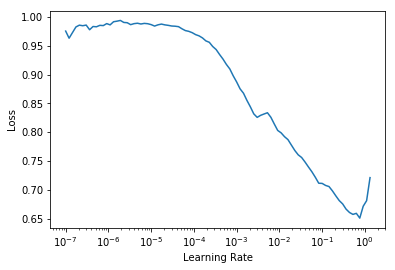

In [76]:
learn.lr_find()

In [16]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()
learn = learn.load_encoder('finetuned')
learn.fit_one_cycle(2, 1.4e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.990357,0.695570,0.492537,00:19
1,0.963424,0.825980,0.500000,00:20


In [17]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.520421,0.514077,0.761194,00:26


In [18]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.656179,0.384731,0.835821,00:34


In [19]:
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.446920,0.376201,0.835821,00:47
1,0.449231,0.343857,0.850746,00:34
2,0.412636,0.320604,0.865672,00:47
3,0.380375,0.301821,0.865672,00:52
4,0.360526,0.283710,0.865672,00:47
5,0.341355,0.274353,0.873134,00:52


### Inference

In [31]:
idx = 0
classes = learn.dls.vocab[1]
pred,pred_idx,probs = learn.predict(dls_clas.valid_ds[idx][0])
actual = int(dls_clas.valid_ds[idx][1])

print(f"Article's actual class: {classes[actual]}\nPrediction: {classes[pred_idx]}; Probability: {probs[pred_idx]:.04f}")

Article's actual class: machine
Prediction: machine; Probability: 0.9916


* **`category`**: actual
* **`category_`**: prediction

In [33]:
learn.show_results()

,text,category,category_
0,"xxbos = xxmaj canning xxmaj dam = \n▁\n▁ xxmaj the xxmaj canning xxmaj dam and reservoir provide a major fresh water resource for the city of xxmaj perth , xxmaj western xxmaj australia . xxmaj the dam is situated on the xxmaj darling xxunk and is an xxunk of the xxmaj canning xxmaj river . xxmaj it is noted for its innovative structural and hydraulic design that was considered to be at the forefront of concrete gravity dam design at the time of construction . xxmaj the xxmaj canning xxmaj dam was xxmaj perth 's primary water supply up until the 1960s when other sources of fresh water were...",machine,machine
1,"xxbos = xxmaj otra xxmaj nota = \n▁\n▁ xxmaj otra xxmaj nota ( xxmaj english : xxmaj another xxmaj note ) is the debut album by xxmaj american singer xxmaj marc xxmaj anthony that was released on xxmaj january 26 , 1993 , by xxup rmm xxmaj records . xxmaj produced by xxmaj sergio xxmaj george , it was the first album by xxmaj anthony to record in salsa after starting his career as a freestyle musician . xxmaj recording of the album began after xxmaj anthony asked xxup rmm president xxmaj ralph xxmaj mercado to record xxmaj juan xxmaj gabriel 's "" xxmaj hasta xxmaj que xxmaj te xxmaj conocí...",human,human
2,xxbos = xxmaj cambodian xxmaj campaign = \n▁\n▁ xxmaj the xxmaj cambodian xxmaj campaign ( also known as the xxmaj cambodian xxunk and the xxmaj cambodian xxmaj invasion ) was a series of military operations conducted in eastern xxmaj cambodia during 1970 by the xxmaj united xxmaj states and the xxmaj republic of xxmaj vietnam ( xxmaj south xxmaj vietnam ) ( xxunk ) during the xxmaj vietnam xxmaj war . xxmaj these xxunk were a result of the policy of xxmaj president xxmaj richard xxmaj nixon . a total of 13 major operations were conducted by the xxmaj army of the xxmaj republic of xxmaj vi...,machine,machine
3,"xxbos = xxmaj scientology in xxmaj germany = \n▁\n▁ xxmaj the xxmaj church of xxmaj scientology has been present in xxmaj germany since 1970 . xxmaj german authorities estimate that there are 4 @,@ xxrep 3 0 active xxmaj scientologists in xxmaj germany today ; the xxmaj church of xxmaj scientology gives a membership figure of around 12 @,@ xxrep 3 0 . xxmaj the xxmaj church of xxmaj scientology has encountered particular xxunk from the xxmaj german press and government and occupies a xxunk legal , social and cultural position in xxmaj germany . xxmaj the xxmaj church of xxmaj scientology w...",machine,human
4,"xxbos = xxmaj far xxmaj away xxmaj places ( xxmaj mad xxmaj men ) = \n▁\n▁ "" xxmaj far xxmaj away xxmaj places "" is the sixth episode of the fifth season of the xxmaj american television drama series xxmaj mad xxmaj men and the xxunk episode of the series overall . xxmaj it was written by series creator and executive producer xxmaj matthew xxmaj xxunk and writer xxunk xxunk , and directed by xxmaj scott xxunk . xxmaj it originally aired on xxup amc in the xxmaj united xxmaj states on xxmaj april 22 , 2012 . \n▁ xxmaj the episode takes place almost entirely over a single day , telling three...",machine,machine
5,"xxbos = xxmaj andrew xxmaj johnston ( singer ) = \n▁\n▁ xxmaj andrew xxmaj johnston ( born 23 xxmaj september 1994 ) is a xxmaj british singer who rose to fame when he appeared as a boy xxunk on the second series of the xxup uk television talent show xxmaj britain 's xxmaj got xxmaj talent in 2008 . xxmaj although he did not win the competition , he received a contract to record with xxmaj xxunk xxmaj music , a label owned by the xxmaj britain 's xxmaj got xxmaj talent judge xxmaj simon xxmaj xxunk . xxmaj johnston 's debut album , xxmaj one xxmaj voice , was released in xxmaj september of...",machine,machine
6,"xxbos = xxmaj silver xxmaj bullet ( roller coaster ) = \n▁\n▁ xxmaj silver xxmaj bullet is a western - themed steel inverted roller coaster designed by xxmaj bolliger & xxmaj mabillard located at xxmaj knott 's xxmaj berry xxmaj farm , an amusement park in 